In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading dataset

In [2]:
df = pd.read_csv('/kaggle/input/taxidata/TaxiData.csv')

# converting the timestamp to date time fromat
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'], unit='s')

### classify columns

classifying all the columns according to the type of values they have

In [3]:
def classify_columns(df):
    column_types = {'categorical': [], 'numerical': [], 'mixed': []}

    for col in df.columns:
        # Check if column has a numeric data type then it is numerical
        if pd.api.types.is_numeric_dtype(df[col]):
            column_types['numerical'].append(col)

        # Check if column has an object or categorical data type
        elif pd.api.types.is_object_dtype(df[col]) or isinstance(df[col].dtype, pd.CategoricalDtype):
            # If the column is primarily strings, it’s likely categorical
            unique_vals = df[col].unique()
            if len(unique_vals) <= df.shape[0] * 0.5:    # arbitrary threshold for uniqueness
                column_types['categorical'].append(col)
            else:
                column_types['mixed'].append(col)

        # For other types or mixed columns, categorize as 'mixed'
        else:
            column_types['mixed'].append(col)

    return column_types

column_types = classify_columns(df)
print(column_types)


{'categorical': ['payment_type', 'company'], 'numerical': ['pickup_community_area', 'fare', 'trip_start_month', 'trip_start_hour', 'trip_start_day', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'trip_seconds', 'dropoff_community_area', 'tips'], 'mixed': ['trip_start_timestamp']}


**Column Classification:**

- **Categorical**: `payment_type`, `company`
- **Numerical**: `pickup_community_area`, `fare`, `trip_start_month`, `trip_start_hour`, `trip_start_day`, `pickup_latitude`, `pickup_longitude`, `dropoff_latitude`, `dropoff_longitude`, `trip_miles`, `pickup_census_tract`, `dropoff_census_tract`, `trip_seconds`, `dropoff_community_area`, `tips`
- **Mixed**: `trip_start_timestamp`


### Missing Value Identification

In [4]:
missing_valueCount = df.isna().sum()
missing_valueCount['company'] = df['company'].isna().sum()

# displaying missing values
print("Missing values at each column: ")
print(missing_valueCount)

# dropping the pickup census track from missing values because entire row isn't filled for this column
missing_valueCount = missing_valueCount.drop("pickup_census_tract")

Missing values at each column: 
pickup_community_area         2
fare                          0
trip_start_month              0
trip_start_hour               0
trip_start_day                0
trip_start_timestamp          0
pickup_latitude               2
pickup_longitude              2
dropoff_latitude            482
dropoff_longitude           482
trip_miles                    0
pickup_census_tract       15001
dropoff_census_tract       4241
payment_type                  0
company                    5140
trip_seconds                  6
dropoff_community_area      506
tips                          0
dtype: int64


### plotting missing values after dropping column 'pickup_census_tract' as no row is filled

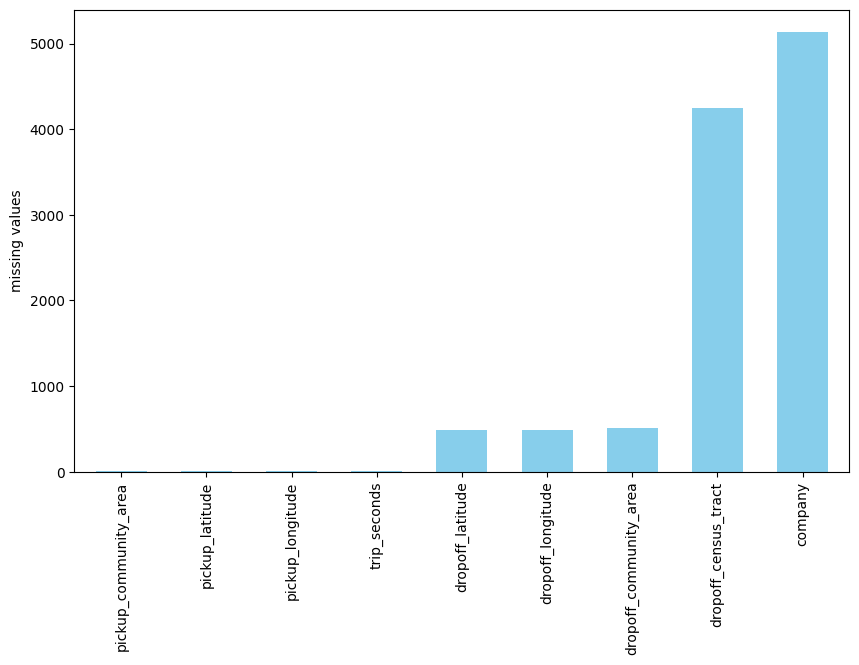

In [5]:
# Visualize missing values in a bar chart
missing_valueCount = missing_valueCount[missing_valueCount>0]
plt.figure(figsize=(10,6))
missing_valueCount.sort_values().plot.bar(color='skyblue', width=0.6)
plt.ylabel("missing values")
plt.show()

### Filling missing values

In [6]:
# List of columns to fill with mode
columns_to_fill = [
    'pickup_community_area', 'trip_start_month', 'trip_start_hour', 
    'trip_start_day', 'dropoff_community_area', 'pickup_census_tract', 
    'dropoff_census_tract'
]

# Fill missing values in each specified column with the mode
for col in columns_to_fill:
    mode_value = df[col].mode()[0]         # Get the mode 
    df[col] = df[col].fillna(mode_value)   # Fill NaN with the mode value

    
# List of float/double columns to fill with median
float_columns = [
    'fare', 'trip_start_timestamp', 'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 'trip_miles', 'trip_seconds'
]

# Fill missing values in each specified column with the median
for col in float_columns:
    median_value = df[col].median()         # Get the median value
    df[col] = df[col].fillna(median_value)  # Fill NaN with the median value


# List of categorical columns for proportional filling
categorical_columns = ['payment_type']

for col in categorical_columns:
    # Get the value frequencies (proportions)
    value_counts = df[col].value_counts(normalize=True)
    
    # Sample missing values according to the frequency distribution
    missing_values_count = df[col].isna().sum()
    sampled_values = value_counts.sample(missing_values_count, replace=True, weights=value_counts).index.tolist()

    # Fill NaN values with sampled values
    df.loc[df[col].isna(), col] = sampled_values

    
# Fill missing values in the 'company' column with 'Other'
df['company'] = df['company'].fillna('Other')


# Verifying if missing values are handled
missing_data_Later_imputation = df.isnull().sum()
print("Missing values after imputation: ")
print(missing_data_Later_imputation)

Missing values after imputation: 
pickup_community_area     0
fare                      0
trip_start_month          0
trip_start_hour           0
trip_start_day            0
trip_start_timestamp      0
pickup_latitude           0
pickup_longitude          0
dropoff_latitude          0
dropoff_longitude         0
trip_miles                0
pickup_census_tract       0
dropoff_census_tract      0
payment_type              0
company                   0
trip_seconds              0
dropoff_community_area    0
tips                      0
dtype: int64


For columns which have **integer values** like 'pickup_community_area', 'trip_start_month', 'trip_start_hour', 'trip_start_day', 'dropoff_community_area', 'pickup_census_tract', 'dropoff_census_tract', filling them with **mode** because **mean** can't fill the integer values.

For the **float or double type** columns like 'fare', 'trip_start_timestamp', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_miles', 'trip_seconds', we are filling them with **median** because mean will have fluctuations due to the presence of outliers in data where median won't have outlier.

For categorical column **'payment_type'** we are filling the value such that the percentage of frequencies of categories remains same.
But for categorical column like **'company'** we are filling empty entries with 'other' as we don't know for sure the company location.

### Type Conversion

In [7]:
# doing the type conversion for dropoff and pickup comunity area
df['pickup_community_area'] = df['pickup_community_area'].astype(int)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(int)


Above column's are converted to integer to manage missing values while preserving numerical format. Also trip_start_timestamp is converted to datetime format for easier time-based analysis and conversions. 

### saving data for model training questions.

In [8]:
df.to_csv('cleaned_taxi_data.csv', index=False)

### Data Refining Unnecessary Code's

In [9]:

# Count trips that ran for zero miles
# zero_count = df.loc[(df['trip_miles'] == 0), 'trip_miles']
# print("trip that are filled zero miles", zero_count.size)

# zero_count = df.loc[(df['fare']==0), 'fare']
# print("trip that are filled zero fare", zero_count.size)
# print('-------------------------------------------')
# zero_count = df.loc[(df['fare']==0) & (df['payment_type']=="No Charge"), 'fare']
# print("trip that are filled zero fare", zero_count.size)
# print('-------------------------------------------')
# zero_count = df.loc[(df['trip_start_month']==0), 'trip_start_month']
# print("trip that are filled zero start month", zero_count.size)

# zero_count = df.loc[(df['trip_start_day']==0), 'trip_start_day']
# print("trip that are filled zero start day", zero_count.size)

# zero_count = df.loc[(df['trip_seconds']==0), 'trip_seconds']
# print("trip that are filled zero duration travel:", zero_count.size)

# zero_count = df.loc[(df['trip_start_timestamp']==0), 'trip_start_timestamp']
# print("trip that are filled zero start timestamp", zero_count.size)

# anomaly_count = df.loc[(df['trip_miles']==0)&(df['fare'] != 0)&(df['trip_seconds']!=0), 'fare']
# print("fare is given but not the trip distance nor duration: ", anomaly_count.size)
# anomaly_count1 = df.loc[(df['trip_miles']!=0)&(df['fare'] != 0)&(df['trip_seconds']!=0), 'fare']
# print("fare is given but not the trip distance nor duration: ", anomaly_count1.size)




# anomaly_count = df.loc[(df['trip_seconds']==0)&(df['fare'] != 0), 'fare']
# print("fare is given but not the trip duration: ", anomaly_count.size)
# anomaly_count = df.loc[(df['trip_seconds']==0)&(df['trip_miles'] != 0), 'fare']
# print("trip_duration not and trip_miles given: ", anomaly_count.size)
# anomaly_count = df.loc[(df['trip_seconds']!=0)&(df['trip_miles'] == 0), 'fare']
# print("trip_duration given and trip_miles not: ", anomaly_count.size)
# print(df.head())